# Install Libraries and get DB Access

In [8]:
!pip install duckdb==1.0.0
!pip list | grep duckdb
!pip install polars==1.3.0
!pip list | grep polars

duckdb                           1.0.0
polars                           1.3.0


In [9]:
# Access lit_panel DB
!curl -IL https://3253-machine-learning.s3.ca-central-1.amazonaws.com/lit_panel_aggr_v3.duckdb
!time wget --no-clobber https://3253-machine-learning.s3.ca-central-1.amazonaws.com/lit_panel_aggr_v3.duckdb

HTTP/1.1 200 OK
x-amz-id-2: A4DaT015qCGFa3jWCATOxgyvPlXdJ8qwfMxLPl+CbF7EeS25ShpJafQfCCcBt1KeeAxdWcI5i2sRFci+aayyFYpkxunSC0ga
x-amz-request-id: 58Q177EB375FVW5G
Date: Thu, 01 Aug 2024 19:05:18 GMT
Last-Modified: Fri, 26 Jul 2024 03:24:09 GMT
ETag: "3f08ffe0a0433c624fb7b08a95ab7ff8-87"
x-amz-server-side-encryption: AES256
Accept-Ranges: bytes
Content-Type: binary/octet-stream
Server: AmazonS3
Content-Length: 728248320

File ‘lit_panel_aggr_v3.duckdb’ already there; not retrieving.


real	0m0.008s
user	0m0.003s
sys	0m0.002s


#Import libraries

In [10]:
import duckdb
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

#Constants

In [11]:
# SYMBOLS = ["AAPL", "AMZN", "AVGO", "GE", "IBM", "JPM", "LLY", "MSFT", "NVDA", "TSLA", "WMT", "XOM", 'ABBV', 'ABT', 'ACN', 'ADBE', 'AMD', 'BK', 'C']
COLUMNS_TO_DROP_AFTER_CLEANSING_PANEL = ['URL']
COLUMNS_TO_DROP_AFTER_PROCESSING_MARKET = ['Open', 'High', 'Low', 'Last', 'Time', 'Change', '%Chg']
COLUMNS_TO_DROP_FROM_COMBINED_DF = []
ACCEPTED_TRANSACTION_CODES = ['C', 'F', 'M', 'O', 'P', 'S', 'D', 'X']
BUY_TRANSACTION_CODES = ['C', 'F', 'M', 'O', 'P', 'X']
SELL_TRANSACTION_CODES = ['S', 'D']
BUY_SELL_WINDOW = 60  # days
NUMERICAL_COLUMNS = ['_total_transaction_shares', 'minSOFT', 'maxSOFT', 'Volume', 'volSumPre', 'volSumPost', 'sell', 'buy']

#Get CSV stock data

In [12]:
!time wget --no-clobber https://3253-machine-learning.s3.ca-central-1.amazonaws.com/market/SP100.zip

!ls -lht

!unzip SP100.zip -d market-data

File ‘SP100.zip’ already there; not retrieving.


real	0m0.006s
user	0m0.001s
sys	0m0.004s
total 706M
drwxr-xr-x 3 root root 4.0K Aug  1 17:51 market-data
drwxr-xr-x 1 root root 4.0K Jul 31 19:25 sample_data
-rw-r--r-- 1 root root  11M Jul 30 16:06 SP100.zip
-rw-r--r-- 1 root root 695M Jul 26 03:24 lit_panel_aggr_v3.duckdb
Archive:  SP100.zip
replace market-data/output/historical-csv/AAPL.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [13]:
# Tell me what I have...
!ls -lah

total 706M
drwxr-xr-x 1 root root 4.0K Aug  1 17:51 .
drwxr-xr-x 1 root root 4.0K Aug  1 17:48 ..
drwxr-xr-x 4 root root 4.0K Jul 31 19:24 .config
-rw-r--r-- 1 root root 695M Jul 26 03:24 lit_panel_aggr_v3.duckdb
drwxr-xr-x 3 root root 4.0K Aug  1 17:51 market-data
drwxr-xr-x 1 root root 4.0K Jul 31 19:25 sample_data
-rw-r--r-- 1 root root  11M Jul 30 16:06 SP100.zip


In [14]:
# These are the stock symbols for which we have CSV files
SYMBOLS = !ls -A1 market-data/output/historical-csv | xargs -I {} basename -s '.csv' {}
print(SYMBOLS)

['AAPL', 'ABBV', 'ABT', 'ACN', 'ADBE', 'AIG', 'AMD', 'AMGN', 'AMT', 'AMZN', 'AVGO', 'AXP', 'BAC', 'BA', 'BK', 'BKNG', 'BLK', 'BMY', 'BRK.B', 'CAT', 'C', 'CHTR', 'CL', 'CMCSA', 'COF', 'COP', 'COST', 'CRM', 'CSCO', 'CVS', 'CVX', 'DE', 'DHR', 'DIS', 'DOW', 'DUK', 'EMR', 'F', 'FDX', 'GD', 'GE', 'GILD', 'GM', 'GOOG', 'GOOGL', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'INTU', 'JNJ', 'JPM', 'KHC', 'KO', 'LIN', 'LLY', 'LMT', 'LOW', 'MA', 'MCD', 'MDLZ', 'MDT', 'META', 'MET', 'MMM', 'MO', 'MRK', 'MS', 'MSFT', 'NEE', 'NFLX', 'NKE', 'NVDA', 'ORCL', 'PEP', 'PFE', 'PG', 'PM', 'PYPL', 'QCOM', 'RTX', 'SBUX', 'SCHW', 'SO', 'SPG', 'T', 'TGT', 'TMO', 'TMUS', 'TSLA', 'TXN', 'UNH', 'UNP', 'UPS', 'USB', 'V', 'VZ', 'WFC', 'WMT', 'XOM']


# DuckDB Connection and Schema Exploration

In [15]:
conn = duckdb.connect('lit_panel_aggr_v3.duckdb')
conn.sql("SELECT * FROM lit_panel_aggr_v3 LIMIT 1").df().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 27 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   URL                                  1 non-null      object 
 1   acceptanceDatetime                   1 non-null      int64  
 2   accessionNumber                      1 non-null      object 
 3   type                                 1 non-null      object 
 4   period                               1 non-null      int64  
 5   issuerCIK                            1 non-null      object 
 6   documentType                         1 non-null      object 
 7   periodOfReport                       1 non-null      object 
 8   notSubjectToSection16                0 non-null      object 
 9   issuerTradingSymbol                  1 non-null      object 
 10  m_isDirector                         1 non-null      int64  
 11  m_isOfficer                         

# Functions (Data Processing)



In [16]:
def load_panel_data(conn, symbol):
    """Load panel data for a given symbol from the DuckDB connection."""
    query = f"""
    SELECT URL, issuerTradingSymbol, period, securityTitle, transactionCode, _total_transaction_shares, _minSharesOwnedFollowingTransaction as minSOFT, _maxSharesOwnedFollowingTransaction as maxSOFT
    FROM lit_panel_aggr_v3
    WHERE issuerTradingSymbol = '{symbol}' AND transactionType = 'nonDerivativeTransaction' AND transactionCode IN {tuple(ACCEPTED_TRANSACTION_CODES)}
    ORDER BY period DESC
    """
    return conn.execute(query).df()

def format_security_title(df, column_name='securityTitle'):
    # Memoized dictionary to store mappings
    memo = {
        'commonStock': set(),
        'restricted': set(),
        'stockUnit': set(),
        'preferredStock': set(),
        'unusedSecurityTitles': set()
    }

    def format_title(title):
        # Convert title to lowercase and remove spaces
        normalized_title = title.lower().replace(' ', '')

        # Check for various conditions and update memo accordingly
        if any(keyword in normalized_title for keyword in ['commonstock', 'common', 'comon', 'ordinary']):
            memo['commonStock'].add(title)
            return 'commonStock'
        elif 'restricted' in normalized_title:
            memo['restricted'].add(title)
            return 'restricted'
        elif 'stockunit' in normalized_title:
            memo['stockUnit'].add(title)
            return 'stockUnit'
        elif any(keyword in normalized_title for keyword in ['capital', 'preferred']):
            memo['preferredStock'].add(title)
            return 'preferredStock'
        else:
            memo['unusedSecurityTitles'].add(title)
            return 'unknown'

    # Apply the format_title function to the specified column
    df[column_name] = df[column_name].apply(format_title)

    return df, memo

def extract_rptOwnerCik(df):
    """Extract the number between the last and second last '/' and add it to a new column."""
    df['rptOwnerCik'] = df['URL'].str.extract(r'/data/(\d+)/')
    return df

def drop_columns(df, columns):
    """Drop specified columns from the DataFrame."""
    return df.drop(columns=columns)

def load_csv(file_path, skipfooter=1):
    """Load a CSV file with the specified skipfooter parameter."""
    return pd.read_csv(file_path, skipfooter=skipfooter, engine='python')

def process_market_data(df):
    """Process market data by calculating percentage changes and setting the datetime index."""
    # Calculate percentage changes
    df['5-30'] = ((df['Last'].shift(30) - df['Last']) / df['Last'] * 100) - ((df['Last'].shift(5) - df['Last']) / df['Last'] * 100)
    df['volSumPre'] = df['Volume'].shift(-1) + df['Volume'].shift(-2) + df['Volume'].shift(-3) + df['Volume'].shift(-4) + df['Volume'].shift(-5)
    df['volSumPost'] = df['Volume'].shift(1) + df['Volume'].shift(2) + df['Volume'].shift(3) + df['Volume'].shift(4) + df['Volume'].shift(5)

    # Parse datetime and set as index
    df['parsed_datetime'] = pd.to_datetime(df['Time'], format='%m/%d/%Y', errors='raise')
    df.set_index('parsed_datetime', inplace=True)

    return df

def drop_rows_from_market_data_where_530_is_nan(df):
    """Drop rows from the market data where the 30-day percentage change is NaN."""
    return df.dropna(subset=['5-30'])

def process_panel_data(df):
    """Process panel data by parsing the datetime and setting it as the index."""
    # Parse datetime
    df['parsed_datetime'] = pd.to_datetime(df['period'], format='%Y%m%d')

    # Set parsed datetime as index
    df.set_index('parsed_datetime', inplace=True)

    return df

def join_panel_market_data(panel_df, market_df):
    """Join panel data with market data on the 'parsed_datetime' index, filling missing values with the most recent date within the past four days."""
    # Perform a left join to keep all rows from panel_df
    joined_df = panel_df.join(market_df, on='parsed_datetime', how='left', rsuffix='_market')

    # Forward fill missing values within the past four days
    joined_df = joined_df.ffill()

    return joined_df

def convert_to_datetime_and_sort(df, column_name):
    """Convert a column to datetime and sort the DataFrame by it."""
    df[column_name] = pd.to_datetime(df[column_name], format='%Y%m%d')
    df = df.sort_values(by=column_name).reset_index(drop=True)
    return df

def process_and_calculate_rolling_sums(df, window=BUY_SELL_WINDOW):
    """Calculate rolling sums for buys and sells for each unique period."""
    # Initialize columns
    df['sell'] = 0.0
    df['buy'] = 0.0

    # Create masks for sell and buy transactions
    sell_mask = df['transactionCode'].isin(SELL_TRANSACTION_CODES)
    buy_mask = df['transactionCode'].isin(BUY_TRANSACTION_CODES)

    # Iterate through each unique period
    unique_periods = df['period'].unique()
    for period in unique_periods:
        # Define the start and end of the rolling window
        end_date = period
        start_date = end_date - pd.Timedelta(days=window)

        # Calculate the rolling sum for sell transactions
        sell_sum = df[sell_mask & (df['period'] > start_date) & (df['period'] <= end_date)]['_total_transaction_shares'].sum()
        df.loc[df['period'] == period, 'sell'] = sell_sum

        # Calculate the rolling sum for buy transactions
        buy_sum = df[buy_mask & (df['period'] > start_date) & (df['period'] <= end_date)]['_total_transaction_shares'].sum()
        df.loc[df['period'] == period, 'buy'] = buy_sum

    return df

def drop_rows_with_nulls(df):
    """Drop rows with null values from the DataFrame."""
    return df.dropna()

def scale_numerical_features(df, numerical_columns):
    # Initialize the MinMaxScaler
    scaler = MinMaxScaler()

    # Apply Min-Max Scaling to the selected columns
    df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

    return df

#Functions  (Testing)



In [17]:
def analyze_chron_data(df):
    """Analyze chron data by filtering for years since 2005 and counting occurrences based on conditions."""
    # Filter the DataFrame for years since 2005
    df = df[df['period'].dt.year >= 2005]

    # Initialize a 3x3 matrix to store the counts
    outcome_matrix = pd.DataFrame(0, index=['buy > sell', 'buy == sell', 'buy < sell'],
                                  columns=['%Chg:5d < -2.0', '-2.0 <= %Chg:5d <= 2.0', '%Chg:5d > 2.0'])

    # Define the conditions
    conditions_buy_sell = [
        (df['buy'] > df['sell']),
        (df['buy'] == df['sell']),
        (df['buy'] < df['sell'])
    ]

    conditions_chg = [
        (df['%Chg:5d'] < -2.0),
        (df['%Chg:5d'] >= -2.0) & (df['%Chg:5d'] <= 2.0),
        (df['%Chg:5d'] > 2.0)
    ]

    # Count the occurrences for each combination of conditions
    for i, cond_buy_sell in enumerate(conditions_buy_sell):
        for j, cond_chg in enumerate(conditions_chg):
            outcome_matrix.iloc[i, j] = df[cond_buy_sell & cond_chg].shape[0]

    return outcome_matrix

def count_nulls_by_issuer(df):
    """Count NULL or NaN values for each column in the DataFrame grouped by issuerTradingSymbol."""
    # Group by 'issuerTradingSymbol' and count NaN values for each column
    null_counts = df.groupby('issuerTradingSymbol').apply(lambda x: x.isna().sum())
    return null_counts

def filter_rows_with_nulls(df):
    """Filter the DataFrame to include only rows with at least one NULL or NaN value."""
    # Filter rows where any column has a NaN value
    filtered_df = df[df.isna().any(axis=1)]
    return filtered_df

def count_total_nulls_in_total_transaction_amount(df):
    """Count total NULL or NaN values in the '_total_transaction_amount' column."""
    total_nulls = df['_total_transaction_amount'].isna().sum()
    return total_nulls

def check_total_transaction_amount_by_transaction_code(df):
    # Group by 'transactionCode' and aggregate counts
    result = df.groupby('transactionCode').agg(
        total_count=('transactionCode', 'size'),
        count_total_transaction_amount_zero=('_total_transaction_amount', lambda x: (x < 5).sum())
    ).reset_index()

    return result

def count_20_percent_difference(df):
    # Calculate the percentage difference
    df['percentage_difference'] = ((df['averageSharePrice'] - df['Last']).abs() / df['Last']) * 100

    # Check if the percentage difference is greater than 20%
    df['is_difference_greater_than_20'] = df['percentage_difference'] > 20

    # Group by transactionCode and aggregate counts
    result = df.groupby('transactionCode').agg(
        total_count=('transactionCode', 'size'),
        count_greater_than_20_percent=('is_difference_greater_than_20', 'sum')
    ).reset_index()

    return result

# Build DF

In [41]:
combined_df_list = []

for stock in SYMBOLS:
    print(f"Processing {stock}")
    panel_df = load_panel_data(conn, stock)
    formatted_df, memo = format_security_title(panel_df)
    formatted_df = extract_rptOwnerCik(formatted_df)
    formatted_df = drop_columns(formatted_df, COLUMNS_TO_DROP_AFTER_CLEANSING_PANEL)
    market_df = load_csv(f"market-data/output/historical-csv/{stock}.csv")
    market_df = process_market_data(market_df)
    market_df = drop_rows_from_market_data_where_530_is_nan(market_df)
    market_df = drop_columns(market_df, COLUMNS_TO_DROP_AFTER_PROCESSING_MARKET)
    formatted_df = process_panel_data(formatted_df)
    joined_df = join_panel_market_data(formatted_df, market_df)
    joined_df = convert_to_datetime_and_sort(joined_df, 'period')
    joined_df = process_and_calculate_rolling_sums(joined_df)
    joined_df = scale_numerical_features(joined_df, NUMERICAL_COLUMNS)
    joined_df = drop_rows_with_nulls(joined_df)

    # Append the joined_df to the list
    combined_df_list.append(joined_df)

# Concatenate all DataFrames in the list into a single DataFrame
combined_df = pd.concat(combined_df_list, ignore_index=True)
combined_df = drop_columns(combined_df, COLUMNS_TO_DROP_FROM_COMBINED_DF)
combined_df.info()

# Show 40 random rows from the df
combined_df.sample(40)

Processing AAPL


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Processing ABBV
Processing ABT
Processing ACN
Processing ADBE
Processing AIG
Processing AMD
Processing AMGN
Processing AMT
Processing AMZN
Processing AVGO
Processing AXP
Processing BAC
Processing BA
Processing BK
Processing BKNG
Processing BLK
Processing BMY
Processing BRK.B
Processing CAT
Processing C
Processing CHTR
Processing CL
Processing CMCSA
Processing COF
Processing COP
Processing COST
Processing CRM


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Processing CSCO
Processing CVS
Processing CVX
Processing DE
Processing DHR
Processing DIS
Processing DOW
Processing DUK
Processing EMR
Processing F
Processing FDX
Processing GD
Processing GE
Processing GILD
Processing GM
Processing GOOG
Processing GOOGL


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:480: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:481: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


Processing GS
Processing HD
Processing HON
Processing IBM
Processing INTC
Processing INTU
Processing JNJ
Processing JPM
Processing KHC
Processing KO
Processing LIN
Processing LLY
Processing LMT
Processing LOW
Processing MA
Processing MCD
Processing MDLZ
Processing MDT
Processing META
Processing MET
Processing MMM
Processing MO
Processing MRK
Processing MS
Processing MSFT
Processing NEE
Processing NFLX
Processing NKE
Processing NVDA
Processing ORCL
Processing PEP
Processing PFE
Processing PG
Processing PM
Processing PYPL
Processing QCOM
Processing RTX
Processing SBUX
Processing SCHW
Processing SO
Processing SPG
Processing T


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Processing TGT
Processing TMO
Processing TMUS
Processing TSLA
Processing TXN
Processing UNH
Processing UNP
Processing UPS
Processing USB
Processing V
Processing VZ
Processing WFC
Processing WMT
Processing XOM
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154449 entries, 0 to 154448
Data columns (total 14 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   issuerTradingSymbol        154449 non-null  object        
 1   period                     154449 non-null  datetime64[ns]
 2   securityTitle              154449 non-null  object        
 3   transactionCode            154449 non-null  object        
 4   _total_transaction_shares  154449 non-null  float64       
 5   minSOFT                    154449 non-null  float64       
 6   maxSOFT                    154449 non-null  float64       
 7   rptOwnerCik                154449 non-null  object        
 8   Volume                     154449 n

,issuerTradingSymbol,period,securityTitle,transactionCode,_total_transaction_shares,minSOFT,maxSOFT,rptOwnerCik,Volume,5-30,volSumPre,volSumPost,sell,buy
66798,GOOG,2004-11-16,commonStock,S,0.000242,0.018459,0.018562,1288776,0.000000,-4.980958,0.317083,0.612173,0.063987,0.581982
45805,CRM,2018-07-22,commonStock,S,0.000023,0.000422,0.000421,1108524,0.037224,7.876712,0.070092,0.154881,0.295930,0.010196
62488,GE,2013-09-12,commonStock,M,0.002001,0.007559,0.006975,1232377,0.025877,6.205459,0.050724,0.064544,0.001815,0.093123
30010,CMCSA,2007-06-08,commonStock,P,0.006363,0.001567,0.001567,1166691,0.334264,3.266236,0.267209,0.557613,0.416396,0.018088
130927,QCOM,2014-05-20,commonStock,F,0.007602,0.000150,0.000209,1559658,0.045882,-0.062610,0.070339,0.032440,0.072157,0.084852
149692,VZ,2021-03-08,commonStock,M,0.017573,0.048730,0.043716,1519341,0.143502,4.842402,0.106686,0.111114,0.001513,0.740447
79932,HD,2018-08-20,commonStock,S,0.001369,0.000990,0.000990,1649314,0.018047,1.399485,0.130619,0.041502,0.003765,0.004096
140988,TSLA,2018-11-01,commonStock,M,0.000039,0.000019,0.000019,1318605,0.165141,-0.865720,0.638655,0.182573,0.000093,0.000854
136231,T,2007-01-25,commonStock,M,0.006096,0.057613,0.050719,1183426,0.104028,-3.261903,0.186940,0.195496,0.747304,0.432806
129148,QCOM,2008-06-13,commonStock,S,0.126509,0.000819,0.000819,1216458,0.214481,9.781956,0.449576,0.320507,0.896933,0.896500


#Build A Model

In [36]:
# Import libraries
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt

# Classification Model

In [67]:
# Load your DataFrame (df)
df = combined_df

# Step 1: Transform the target variable into categorical labels
def categorize_change(value):
    if value > 10:
        return 1
    else:
        return 0

df['5-30_cat'] = df['5-30'].apply(categorize_change)
target_column = '5-30_cat'

# Three types of splits
# # 1. Split by date
# train_df = df[(df['period'] < pd.to_datetime('2013-04-01')) | (df['period'] >= pd.to_datetime('2016-04-01'))]
# test_df = df[(df['period'] >= pd.to_datetime('2013-04-01')) & (df['period'] < pd.to_datetime('2016-04-01'))]
# train_sample = train_df.sample(frac=0.6, random_state=42)
# test_sample = test_df.sample(frac=0.6, random_state=42)

# X_train = train_sample.drop(columns=['5-30', '5-30_cat', 'period', 'securityTitle', 'rptOwnerCik', 'issuerTradingSymbol'])
# y_train = train_sample[target_column]

# X_test = test_sample.drop(columns=['5-30', '5-30_cat', 'period', 'securityTitle', 'rptOwnerCik', 'issuerTradingSymbol'])
# y_test = test_sample[target_column]

# # 2. Split by stocks
# split_index = int(len(SYMBOLS) * 0.8)
# train_symbols = SYMBOLS[:split_index]
# test_symbols = SYMBOLS[split_index:]

# train_df = df[df['issuerTradingSymbol'].isin(train_symbols)]
# test_df = df[df['issuerTradingSymbol'].isin(test_symbols)]
# train_sample = train_df.sample(frac=0.6, random_state=42)
# test_sample = test_df.sample(frac=0.6, random_state=42)

# X_train = train_sample.drop(columns=['5-30', '5-30_cat', 'period', 'securityTitle', 'rptOwnerCik', 'issuerTradingSymbol'])
# y_train = train_sample[target_column]

# X_test = test_sample.drop(columns=['5-30', '5-30_cat', 'period', 'securityTitle', 'rptOwnerCik', 'issuerTradingSymbol'])
# y_test = test_sample[target_column]

# 3. Random Split
X = df.drop(columns=['5-30', '5-30_cat', 'period', 'securityTitle', 'rptOwnerCik', 'issuerTradingSymbol'])
y = df[target_column]

X_train, X_remaining, y_train, y_remaining = train_test_split(X, y, test_size=0.6, random_state=42)
X_test, X_discard, y_test, y_discard = train_test_split(X_remaining, y_remaining, test_size=0.20, random_state=42)

# Identify categorical features
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()
numeric_features = X_train.select_dtypes(exclude=['object']).columns.tolist()

# Create a preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Apply SMOTE and train the model within a pipeline
pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(class_weight={0: 1, 1: 10}, random_state=42))
])

# Train the model
pipeline.fit(X_train, y_train)

# Evaluate the model with adjusted threshold
y_pred_proba = pipeline.predict_proba(X_test)
threshold = 0.9  # Adjust the threshold to increase precision
y_pred = (y_pred_proba[:, 1] >= threshold).astype(int)

print(classification_report(y_test, y_pred))
precision = precision_score(y_test, y_pred)
print(f'Precision: {precision}')

              precision    recall  f1-score   support

           0       0.91      1.00      0.95    103876
           1       0.96      0.11      0.20     11961

    accuracy                           0.91    115837
   macro avg       0.93      0.55      0.57    115837
weighted avg       0.91      0.91      0.87    115837

Precision: 0.9575091575091575


Summed Feature Importances:
  Original Feature                                            Feature  \
0           Volume                                             Volume   
1       volSumPost                                         volSumPost   
2        volSumPre                                          volSumPre   
3              buy                                                buy   
4             sell                                               sell   
5                                           _total_transaction_shares   
6          maxSOFT                                            maxSOFT   
7          minSOFT                                            minSOFT   
8  transactionCode  transactionCode_CtransactionCode_DtransactionC...   

   Importance  
0    0.155417  
1    0.133672  
2    0.129986  
3    0.126021  
4    0.120342  
5    0.104491  
6    0.094975  
7    0.094124  
8    0.040974  


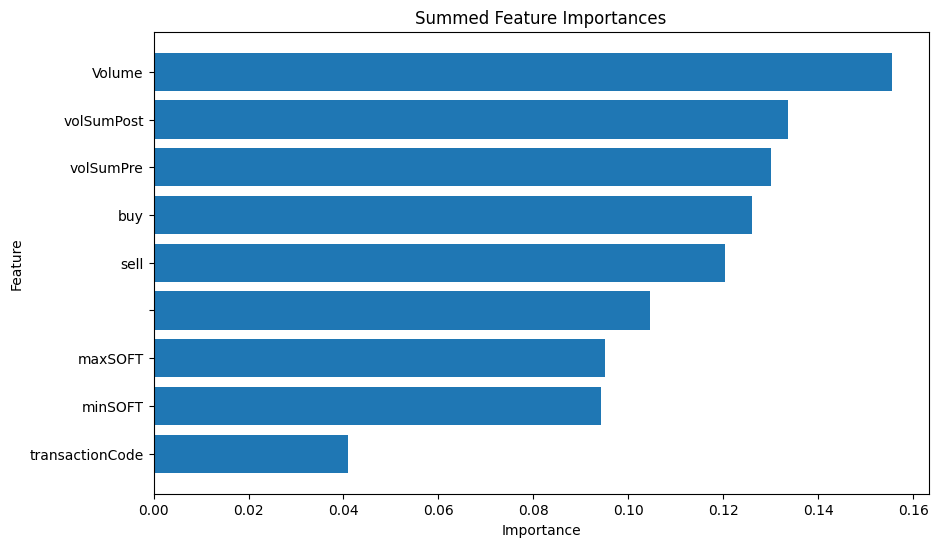

In [68]:
# Get feature importances
classifier = pipeline.named_steps['classifier']
importances = classifier.feature_importances_

# Get feature names after preprocessing
feature_names = numeric_features + list(pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_features))

# Create a DataFrame for feature importances
feature_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sum the importances for rptOwnerCik, transactionCode, and issuerTradingSymbol
feature_importances_df['Original Feature'] = feature_importances_df['Feature'].str.split('_').str[0]
summed_importances_df = feature_importances_df.groupby('Original Feature').sum().sort_values(by='Importance', ascending=False).reset_index()

print("Summed Feature Importances:")
print(summed_importances_df)

# Plot the summed feature importances
plt.figure(figsize=(10, 6))
plt.barh(summed_importances_df['Original Feature'], summed_importances_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Summed Feature Importances')
plt.gca().invert_yaxis()
plt.show()

#Regression Model

In [26]:
# Load your DataFrame (df)
df = combined_df

# Choose or compute the target variable (y)
df['target'] = df['5-30']

# Filter the DataFrame for training set dates
train_df = df[df['period'] < pd.to_datetime('2020-04-01')]
test_df = df[df['period'] >= pd.to_datetime('2020-04-01')]

# Sample 20% of each DataFrame
train_sample = train_df.sample(frac=0.2, random_state=42)
test_sample = test_df.sample(frac=0.2, random_state=42)

# Define the features (X) and target (y)
features = [
    'issuerTradingSymbol', 'volSumPre', 'volSumPost', 'Volume',
    'securityTitle', 'transactionCode', '_total_transaction_shares', 'minSOFT', 'maxSOFT',
    'rptOwnerCik', 'sell', 'buy'
]
X_train = train_sample[features]
y_train = train_sample['target']

X_test = test_sample[features]
y_test = test_sample['target']

# Verify the shapes of the splits
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Preprocess the data
numeric_features = [
    '_total_transaction_shares', 'minSOFT', 'maxSOFT',
    'sell', 'buy', 'volSumPre', 'volSumPost', 'Volume',
]
categorical_features = [
    'transactionCode', 'rptOwnerCik', 'issuerTradingSymbol'
]

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Define the model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

X_train shape: (25509, 12)
X_test shape: (5381, 12)
y_train shape: (25509,)
y_test shape: (5381,)


In [27]:
# Train the model
model.fit(X_train, y_train)

# Optionally, evaluate the model
print(f"Training score: {model.score(X_train, y_train)}")

Training score: 0.9264457052985169


In [28]:
# Make predictions
y_pred = model.predict(X_test)

print(f"Test score: {model.score(X_test, y_test)}")

Test score: -0.10910823585802065


In [29]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 100.34648010555391


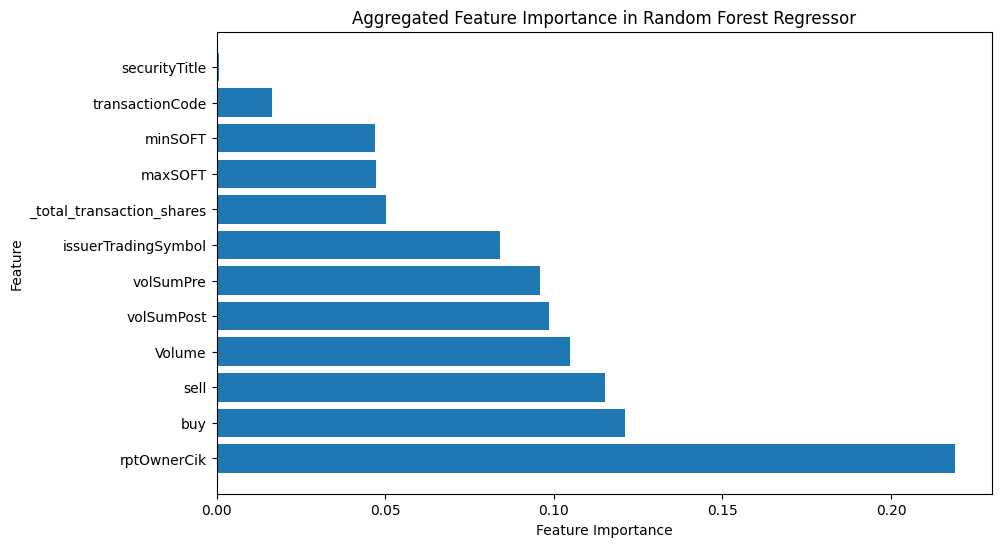

In [30]:
# Feature Importance
feature_importances = model.named_steps['regressor'].feature_importances_
onehot_columns = model.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_features)
all_features = np.concatenate([numeric_features, onehot_columns])

# Create a DataFrame to display feature importances
feature_importance_df = pd.DataFrame({
    'Feature': all_features,
    'Importance': feature_importances
})

# Aggregate importances for each categorical feature
aggregated_importances = {}

for feature in categorical_features:
    # Find all one-hot encoded columns for this feature
    matching_columns = [col for col in onehot_columns if col.startswith(feature)]
    # Sum their importances
    total_importance = feature_importance_df[feature_importance_df['Feature'].isin(matching_columns)]['Importance'].sum()
    aggregated_importances[feature] = total_importance

# Add numeric features to the aggregated importances
for feature in numeric_features:
    total_importance = feature_importance_df[feature_importance_df['Feature'] == feature]['Importance'].sum()
    aggregated_importances[feature] = total_importance

# Create a DataFrame for aggregated importances
aggregated_importance_df = pd.DataFrame(list(aggregated_importances.items()), columns=['Feature', 'Importance'])

# Sort the DataFrame by importance
aggregated_importance_df = aggregated_importance_df.sort_values(by='Importance', ascending=False)

# Plot the aggregated feature importances
plt.figure(figsize=(10, 6))
plt.barh(aggregated_importance_df['Feature'], aggregated_importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Aggregated Feature Importance in Random Forest Regressor')
plt.show()

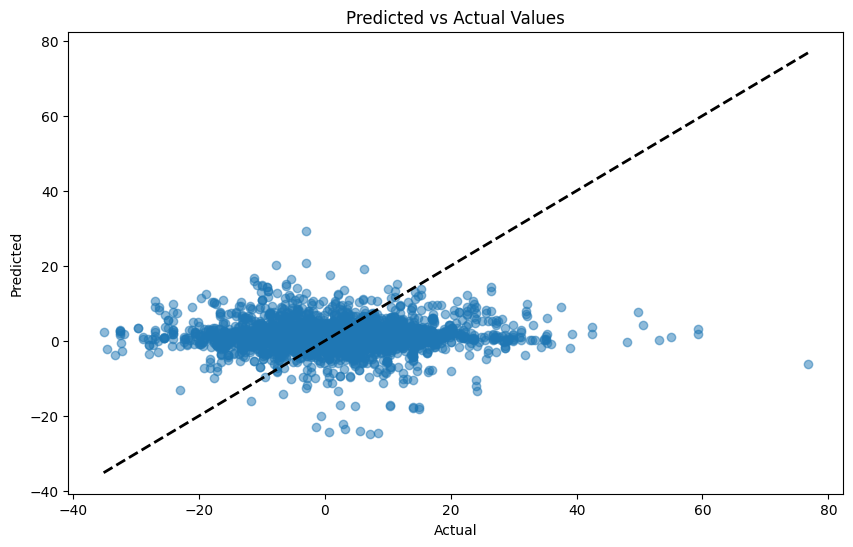

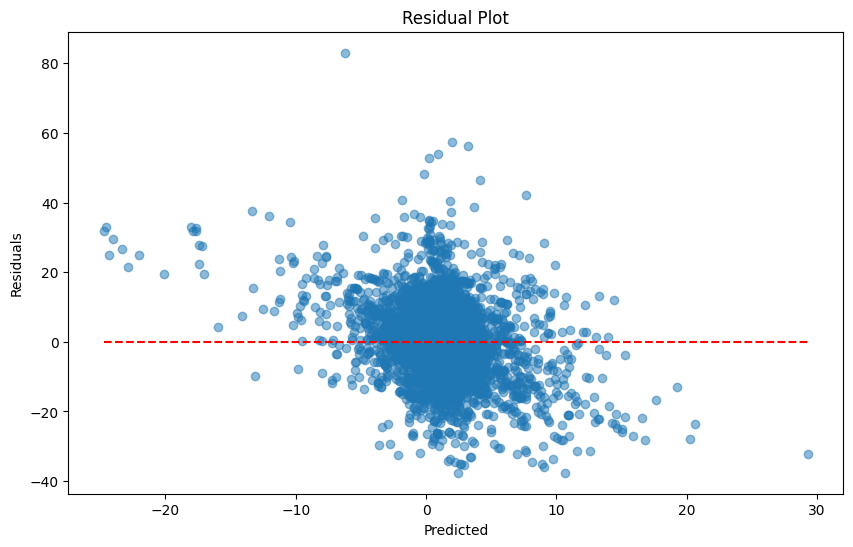

In [31]:
# Predicted vs Actual Values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Predicted vs Actual Values')
plt.show()

# Residual Plot
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.hlines(0, y_pred.min(), y_pred.max(), colors='r', linestyles='dashed')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()